In [65]:
#Imports
import pandas as pd
import numpy as np
import os
import random
from datetime import date, datetime, timedelta

pd.set_option("display.max.columns", None)

In [66]:
#MasterData, Input file path
Separator = ','
SALES_CSV_PATH = 'myS4SSalesOrders_001.csv'
PAYMENT_CSV_PATH = os.path.join('out', 'paymentData.csv')
MERGE_CSV_PATH = os.path.join('out', 'mergeData.csv')

#parameters
OUTPUT_COLS =['PaymentNr', 'SalesOrderNr', 'CustomerNr', 'CustomerName', 'PaymentDate', 'Value']
startPaymentNr = 30000
paymentTermDue = 60
custGroupSettingsDict = {'CustomerGroup' : ['Z1', 'Z2'],
                         'PayOffset' : [30, 70], #Nr of days after billing date by when customer pays
                         'PayOffsetVariance' : [5, 10]}
custGroupSettingsDf = pd.DataFrame(custGroupSettingsDict)
custGroupSettingsDf.set_index("CustomerGroup", inplace=True)
display(custGroupSettingsDf)


,PayOffset,PayOffsetVariance
CustomerGroup,,
Z1,30,5
Z2,70,10


In [67]:
print(custGroupSettingsDf.iloc[1])

PayOffset            70
PayOffsetVariance    10
Name: Z2, dtype: int64


In [68]:
#How to select in DF : https://appdividend.com/2020/04/28/python-how-to-select-rows-from-pandas-dataframe/
print(custGroupSettingsDf.loc['Z1'])


PayOffset            30
PayOffsetVariance     5
Name: Z1, dtype: int64


In [69]:
print(custGroupSettingsDf.loc['Z1'].PayOffset)

30


In [70]:
# Read the Csv Input file
#salesDataDf = pd.read_csv(SALES_CSV_PATH, header=[0], nrows = 100, sep = Separator, parse_dates=[1, 3, 10, 14])
salesDataDf = pd.read_csv(SALES_CSV_PATH, header=[0], sep = Separator, parse_dates=[1, 3, 10, 14])
salesDataDf.set_index("SALESDOCUMENT", inplace=True)
display(salesDataDf)

,BILLINGCOMPANYCODE,BILLINGDOCUMENTDATE,COUNTRY,CREATIONDATE,CREATIONTIME,CREDITCONTROLAREA,CUSTOMERGROUP,CUSTOMERNAME,DISTRIBUTIONCHANNEL,HEADERBILLINGBLOCKREASON,LASTCHANGEDATE,LASTCHANGEDATETIME,MANDT,ORGANIZATIONDIVISION,PRICINGDATE,PURCHASEORDERBYCUSTOMER,SALESDOCUMENTPROCESSINGTYPE,SALESDOCUMENTTYPE,SALESGROUP,SALESOFFICE,SALESORGANIZATION,SDDOCUMENTCATEGORY,SOLDTOPARTY,TOTALNETAMOUNT,TRANSACTIONCURRENCY,CITYNAME
SALESDOCUMENT,,,,,,,,,,,,,,,,,,,,,,,,,,
2564,1710,2020-02-01,US,2020-02-03,222008,A000,Z1,Rolling Bike Shop,10,NaN,00000000,2.020020e+13,100,0,2020-02-01,4500027782,NaN,TA,NaN,NaN,1710,C,USCU_S13,20631.0,USD,MONTGOMERY
2565,1710,2020-02-01,US,2020-02-03,222008,A000,Z2,Quotex,10,NaN,00000000,2.020020e+13,100,0,2020-02-01,4500027756,NaN,TA,NaN,NaN,1710,C,USCU_L04,23805.0,USD,RALEIGH
4,1710,2017-10-08,US,2017-10-08,234228,A000,Z2,CostClub,10,NaN,00000000,2.017101e+13,100,0,2017-10-08,4500045090,NaN,TA,NaN,NaN,1710,C,USCU_L10,20020.0,USD,PUBLIC SQUARE
2566,1710,2020-02-01,US,2020-02-03,222009,A000,Z2,Bigmart,10,NaN,00000000,2.020020e+13,100,0,2020-02-01,4500027810,NaN,TA,NaN,NaN,1710,C,USCU_L09,22218.0,USD,DETROIT
1859,1710,2019-10-22,US,2019-10-22,70955,1000,01,Domestic US Customer 5 (CMS),10,NaN,20200122,2.020012e+13,100,0,2019-10-22,145,NaN,TA,NaN,NaN,1710,C,0017100005,175.5,USD,Billings
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3289,1710,2020-06-03,US,2020-06-03,192758,A000,Z1,Gogo Bikes,10,NaN,20200603,2.020060e+13,100,0,2020-06-03,4500037167,NaN,TA,NaN,NaN,1710,C,USCU_S16,960.0,USD,Milwaukee
3290,1710,2020-06-03,US,2020-06-03,192758,A000,Z2,Bluestar Corp,10,NaN,20200603,2.020060e+13,100,0,2020-06-03,4500037077,NaN,TA,NaN,NaN,1710,C,USCU_L05,2720.0,USD,CHARLESTON
3291,1710,2020-06-03,US,2020-06-03,192759,A000,Z1,Fit Cycles,10,NaN,20200603,2.020060e+13,100,0,2020-06-03,4500037048,NaN,TA,NaN,NaN,1710,C,USCU_S04,1920.0,USD,PORTLAND


In [71]:
print(salesDataDf.dtypes)
print(salesDataDf.dtypes[14])

BILLINGCOMPANYCODE                      int64
BILLINGDOCUMENTDATE            datetime64[ns]
COUNTRY                                object
CREATIONDATE                   datetime64[ns]
CREATIONTIME                            int64
CREDITCONTROLAREA                      object
CUSTOMERGROUP                          object
CUSTOMERNAME                           object
DISTRIBUTIONCHANNEL                     int64
HEADERBILLINGBLOCKREASON              float64
LASTCHANGEDATE                         object
LASTCHANGEDATETIME                    float64
MANDT                                   int64
ORGANIZATIONDIVISION                    int64
PRICINGDATE                    datetime64[ns]
PURCHASEORDERBYCUSTOMER                object
SALESDOCUMENTPROCESSINGTYPE           float64
SALESDOCUMENTTYPE                      object
SALESGROUP                            float64
SALESOFFICE                           float64
SALESORGANIZATION                       int64
SDDOCUMENTCATEGORY                

In [72]:
customerGroup = 'Z3'
if customerGroup in ['Z1', 'Z2']:
    print('yes')
else:
    print('no')

no


In [73]:
#Loop over the SalesData and determine the payment data
paymentDf = pd.DataFrame(columns=OUTPUT_COLS)
paymentNr = startPaymentNr - 1
for index, salesRow in salesDataDf.iterrows():
    paymentNr = paymentNr + 1
    salesOrderNr = index
    customerNr = salesRow['SOLDTOPARTY']
    customerName = salesRow['CUSTOMERNAME']
    customerGroup = salesRow['CUSTOMERGROUP']
    paymentDueDate = salesRow['BILLINGDOCUMENTDATE'] + timedelta(paymentTermDue)
    paymentValue = salesRow['TOTALNETAMOUNT']
    
    if(customerGroup in ['Z1', 'Z2']):
        variance = custGroupSettingsDf.loc[customerGroup].PayOffsetVariance
        randomoffset = (random.randint(1, 2 * variance)) - variance
        offsetd = round(custGroupSettingsDf.loc[customerGroup].PayOffset + randomoffset, 0)
        #convert numpy.int64 to int to support timedelta
        offset = int(offsetd)
    else:
        offset = 10
    
    paymentDate = salesRow['BILLINGDOCUMENTDATE'] + timedelta(offset)

    paymentDf=paymentDf.append({'PaymentNr' : paymentNr,
                                'SalesOrderNr' : salesOrderNr, 
                                'CustomerNr' : customerNr,
                                'CustomerName' : customerName, 
                                'CustomerGroup' : customerGroup,
                                'PaymentDate' : paymentDate,
                                'PaymentOffSet' : offset,
                                'PaymentDueDate' : paymentDueDate,
                                'Value' : paymentValue,
                                #'CustomerGroup2' : customerGroup,
                                'variance' : variance,
                                'randomoffset' : randomoffset,
                                'offset' : offset,
                                'BillingDate' : salesRow['BILLINGDOCUMENTDATE']
                               }, ignore_index=True)

paymentDf.head()
#display(paymentDf)
#print("Invoice Dataframe Contents ", paymentDf, sep='\n')    

,PaymentNr,SalesOrderNr,CustomerNr,CustomerName,PaymentDate,Value,BillingDate,CustomerGroup,PaymentDueDate,PaymentOffSet,offset,randomoffset,variance
0,30000,2564,USCU_S13,Rolling Bike Shop,2020-03-06,20631.0,2020-02-01,Z1,2020-04-01,34.0,34.0,4.0,5.0
1,30001,2565,USCU_L04,Quotex,2020-04-10,23805.0,2020-02-01,Z2,2020-04-01,69.0,69.0,-1.0,10.0
2,30002,4,USCU_L10,CostClub,2017-12-22,20020.0,2017-10-08,Z2,2017-12-07,75.0,75.0,5.0,10.0
3,30003,2566,USCU_L09,Bigmart,2020-04-21,22218.0,2020-02-01,Z2,2020-04-01,80.0,80.0,10.0,10.0
4,30004,1859,0017100005,Domestic US Customer 5 (CMS),2019-11-01,175.5,2019-10-22,01,2019-12-21,10.0,10.0,10.0,10.0


In [74]:
paymentDf.describe()

,Value,PaymentOffSet,offset,randomoffset,variance
count,2987.000000,2987.000000,2987.000000,2987.000000,2987.000000
mean,26884.765819,45.452628,45.452628,0.444258,7.353532
std,46030.146770,22.997263,22.997263,4.433760,2.496124
min,0.000000,10.000000,10.000000,-9.000000,5.000000
25%,2240.000000,29.000000,29.000000,-3.000000,5.000000
50%,9450.000000,34.000000,34.000000,0.000000,5.000000
75%,28504.000000,69.000000,69.000000,4.000000,10.000000
max,487683.000000,80.000000,80.000000,10.000000,10.000000


In [75]:
paymentDf.groupby("CustomerGroup").describe()

Value                                                         \
                count          mean           std    min       25%       50%   
CustomerGroup                                                                  
01              319.0   1306.639185   5184.744815   0.00     0.000     70.20   
02               11.0    854.645455   2374.019766  17.55    33.025     87.75   
Z1             1368.0  37192.425439  60404.681466   0.00  2400.000   8890.00   
Z2             1287.0  22532.372183  27078.145872   0.00  6820.000  13335.00   

                                  PaymentOffSet                             \
                    75%       max         count       mean       std   min   
CustomerGroup                                                                
01               175.50   69220.0         319.0  10.000000  0.000000  10.0   
02               263.25    8000.0          11.0  10.000000  0.000000  10.0   
Z1             51701.00  487683.0        1368.0  30.545322  2.820293  26.0   
Z2             27182.00  246574.0        1287.0  70.443667  5.799372  61.0   

                                       offset                             \
                25%   50%   75%   max   count       mean       std   min   
CustomerGroup                                                              
01             10.0  10.0  10.0  10.0   319.0  10.000000  0.000000  10.0   
02             10.0  10.0  10.0  10.0    11.0  10.000000  0.000000  10.0   
Z1             28.0  30.0  33.0  35.0  1368.0  30.545322  2.820293  26.0   
Z2             65.0  70.0  76.0  80.0  1287.0  70.443667  5.799372  61.0   

                                      randomoffset                           \
                25%   50%   75%   max        count      mean       std  min   
CustomerGroup                                                                 
01             10.0  10.0  10.0  10.0        319.0  0.040752  3.740174 -9.0   
02             10.0  10.0  10.0  10.0         11.0 -0.636364  2.013590 -6.0   
Z1             28.0  30.0  33.0  35.0       1368.0  0.545322  2.820293 -4.0   
Z2             65.0  70.0  76.0  80.0       1287.0  0.443667  5.799372 -9.0   

                                   variance                                   \
               25%  50%  75%   max    count       mean       std   min   25%   
CustomerGroup                                                                  
01            -3.0  0.0  2.0  10.0    319.0   6.755486  2.390316   5.0   5.0   
02            -0.5  0.0  0.0   2.0     11.0   7.727273  2.611165   5.0   5.0   
Z1            -2.0  0.0  3.0   5.0   1368.0   5.000000  0.000000   5.0   5.0   
Z2            -5.0  0.0  6.0  10.0   1287.0  10.000000  0.000000  10.0  10.0   

                                 
                50%   75%   max  
CustomerGroup                    
01              5.0  10.0  10.0  
02             10.0  10.0  10.0  
Z1              5.0   5.0   5.0  
Z2             10.0  10.0  10.0

In [76]:
#Write to csv file
paymentDf.to_csv(PAYMENT_CSV_PATH, header=True, columns = OUTPUT_COLS, sep=';')   


#ToDo : calculate mean offset per customergroup

In [77]:
%matplotlib inline

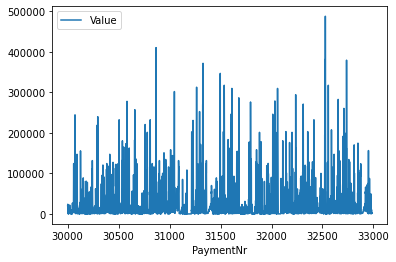

In [78]:
paymentDf.plot(x="PaymentNr", y=["Value"])

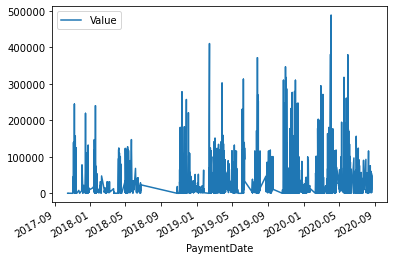

In [79]:
paymentDf.plot(x="PaymentDate", y="Value")

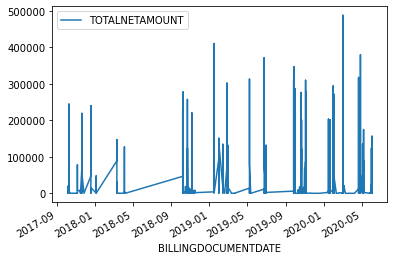

In [80]:
salesDataDf.plot(x='BILLINGDOCUMENTDATE', y='TOTALNETAMOUNT')

In [81]:
#Merging the time series
#Sum first on dates and then Merge
#Pandas GroupBy Documentation https://realpython.com/pandas-groupby/
tSalesValue = salesDataDf.groupby('BILLINGDOCUMENTDATE')['TOTALNETAMOUNT'].sum()
tSalesValue.head(10)
#salesDataDf["MergeDate"] = tSalesValue['BILLINGDOCUMENTDATE']


BILLINGDOCUMENTDATE
2017-10-06        175.50
2017-10-08      20020.00
2017-10-09     153931.40
2017-10-10    1776779.00
2017-10-16         67.60
2017-10-17        121.55
2017-10-18         52.65
2017-10-19         70.20
2017-10-23        245.70
2017-10-24        105.30
Name: TOTALNETAMOUNT, dtype: float64

In [82]:
tPaymentValue = paymentDf.groupby('PaymentDate')['Value'].sum()
tPaymentValue.head(10)

PaymentDate
2017-10-16       175.50
2017-10-19       491.40
2017-10-26        67.60
2017-10-27       121.55
2017-10-28        52.65
2017-10-29        70.20
2017-11-02       245.70
2017-11-03       105.30
2017-11-05    205499.00
2017-11-06     13700.00
Name: Value, dtype: float64

In [83]:
#paymentDf.head()
mergeDf = pd.merge(tSalesValue ,tPaymentValue , how='outer', left_index=True, right_index=True)
mergeDf['TOTALNETAMOUNT'] = mergeDf['TOTALNETAMOUNT'].fillna(0)
mergeDf['Value'] = mergeDf['Value'].fillna(0)
mergeDf.head(10)
mergeDf.to_csv(MERGE_CSV_PATH, header=True, sep=';')  

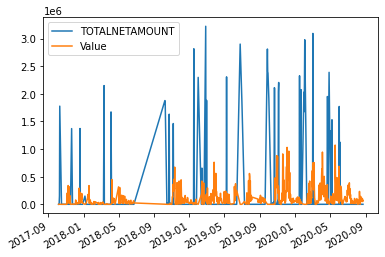

In [84]:
#Info on Plotting with Pandas https://realpython.com/pandas-plot-python/
mergeDf.plot(y=['TOTALNETAMOUNT', 'Value'])

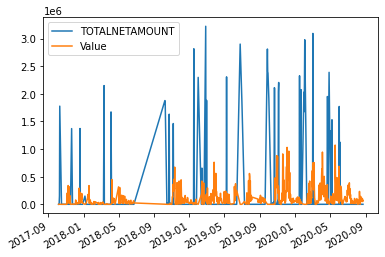

In [85]:
mergeDf.plot()